# West Nile Virus Prediction

### 1. Import Data and Libraries

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, asin, sqrt
from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline

In [237]:
spray = pd.read_csv('./west_nile/west_nile/input/spray.csv')
weather = pd.read_csv('./west_nile/west_nile/input/weather.csv')
train = pd.read_csv('./west_nile/west_nile/input/train.csv')
sample = pd.read_csv('./west_nile/west_nile/input/SampleSubmission.csv')
test = pd.read_csv('./west_nile/west_nile/input/test.csv')

In [238]:
#use to assign weather data to traps based on distance from weather station to trap

def haversine(lat1, lon1, lat2, lon2):
    '''Calculates the distance between two lat-long points.'''
    
    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c

### 2. Perform EDA /Format /Clean Data

In [239]:
def quick_EDA(df):
    #Input a dataframe, Returns: shape of data, number of nulls
    nulls = df.isnull().sum().sum()
    
    print('Rows:', df.shape[0], 'Columns:', df.shape[1])
    print('Total NaNs:', nulls)

In [240]:
#Converting columns to datetime format
def convert_datetime(df):
    df['Date'] = pd.to_datetime(df['Date'])

In [241]:
#converting spray columns to date time and making date/time columns
def convert_spray(df):
    df['Date'] = pd.to_datetime(spray['Date'])
    df['am_pm'] = df['Time'].apply(lambda x: str(x).split()[-1])
    df['Time'] = df['Time'].apply(lambda x: str(x).split()[0])
    df['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

In [242]:
quick_EDA(train)

Rows: 10506 Columns: 12
Total NaNs: 0


In [243]:
quick_EDA(spray)

Rows: 14835 Columns: 4
Total NaNs: 584


In [244]:
quick_EDA(weather)

Rows: 2944 Columns: 22
Total NaNs: 0


In [245]:
quick_EDA(test)

Rows: 116293 Columns: 11
Total NaNs: 0


In [246]:
#Looking at mosquitos and wnv present by date by trap
train[(train['Date'] == '2013-08-29') & (train['Trap'] == 'T900')].head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
9972,2013-08-29,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,29,0


In [247]:
#Looking at mosquitos and wnv present by date by trap
train.groupby(by = ['Date', 'Trap'])['NumMosquitos', 'WnvPresent'].sum().sort_values('WnvPresent', ascending = False).head()

,,NumMosquitos,WnvPresent
Date,Trap,,
2013-08-29,T900,608,12
2007-08-16,T115,2636,11
2013-09-06,T900,550,9
2013-08-01,T900,984,9
2007-08-22,T138,1124,7


In [248]:
#converting date time
dfs = [train, test, weather]

for df in dfs:
    convert_datetime(df)

In [249]:
#converting spray data
convert_spray(spray)

In [250]:
'''#testing to see if any traps are ever tested more than once on the same day
    # none are, this will allow us to determine the number of mosquitos in traps where there are more than 50
    # because we can now combine rows on Trap Id and Date to get total no. mosquitos tested
datetrap = train[['Date', 'Trap']]
y = datetrap.merge(pd.get_dummies(train['Trap']), how = 'left', right_index = True, left_index = True)

datetrapcols = y.shape[1]
datetraprows = y.shape[0]
errors = 0

for i in range(datetraprows):
    for g in range(2,datetrapcols):
        if y.iloc[i,g] > 1:
            errors += 1
print('Traps tested > 1/day:', errors)'''

"#testing to see if any traps are ever tested more than once on the same day\n    # none are, this will allow us to determine the number of mosquitos in traps where there are more than 50\n    # because we can now combine rows on Trap Id and Date to get total no. mosquitos tested\ndatetrap = train[['Date', 'Trap']]\ny = datetrap.merge(pd.get_dummies(train['Trap']), how = 'left', right_index = True, left_index = True)\n\ndatetrapcols = y.shape[1]\ndatetraprows = y.shape[0]\nerrors = 0\n\nfor i in range(datetraprows):\n    for g in range(2,datetrapcols):\n        if y.iloc[i,g] > 1:\n            errors += 1\nprint('Traps tested > 1/day:', errors)"

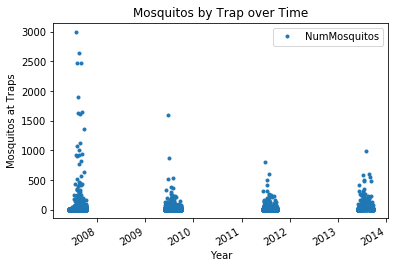

In [251]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time')
plt.xlabel('Year')
plt.ylabel('Mosquitos at Traps');

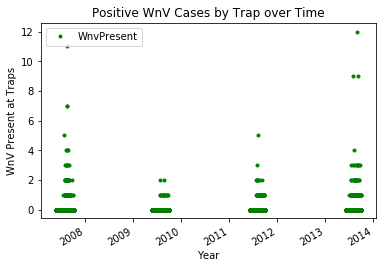

In [255]:
#plotted WNV incidents by trap
train[['Date', 'Trap','WnvPresent']].groupby(by = ['Date','Trap'])['Date','Trap','WnvPresent'] \
    .sum().reset_index().sort_values('WnvPresent', ascending = False).set_index('Date').plot(color = 'green', style = '.')
    
plt.title('Positive WnV Cases by Trap over Time')
plt.xlabel('Year')
plt.ylabel('WnV Present at Traps');

### 3. Feature Engineering

##### Pair weather data with trap locations

In [54]:
#assign weather station to trap based on location
def assign_station(df):
    stat1lat = 41.995
    stat1long = -87.933
    stat2lat = 41.786
    stat2long = -87.752 

    df['Station'] = 1

    for i in range(df.shape[0]):
        if haversine(stat1lat, stat1long, df.loc[i, 'Latitude'], df.loc[i, 'Longitude']) > haversine(stat2lat, stat2long, df.loc[i, 'Latitude'], df.loc[i, 'Longitude']):
            df.loc[i,'Station'] = 2

In [55]:
#assign a station to traps in train and test data
assign_station(train)
assign_station(test)

In [56]:
#perform cleaning on weather data set before merging


#drop columns not being used
weather.drop(columns = ['SeaLevel','CodeSum', 'Sunrise', 'Sunset','Depart','Depth','Water1', 'SnowFall', 'Cool', 'Heat'], inplace = True)

#impute missing values from previous days values, days are sequential so using the 
#previous day's value should be a pretty good estimator
weathercols = weather.columns.tolist()

for col in weathercols:
    for row in range(weather.shape[0]):
        if weather.loc[row, col] == 'M' or weather.loc[row, col] == '  T':
            weather.loc[row, col] = weather.loc[row - 1, col]

In [57]:
#change data types
weatherobjs = ['Tavg', 'WetBulb', 'PrecipTotal', 'StnPressure', 'AvgSpeed']

for col in weatherobjs:
    weather[col] = pd.to_numeric(weather[col])

In [58]:
#split out weather data by station so it can be processed/feature engineered
weathstat1 = weather[weather['Station'] ==1].reset_index(drop = True)
weathstat2 = weather[weather['Station'] ==2].reset_index(drop = True)


In [59]:
#Getting days since last rain
def days_since_last_rain(df):
    
    raindays = 0

    for i in range(df.shape[0]):
        if df.loc[i,'PrecipTotal'] == 0:
            raindays += 1        
            df.loc[i, 'days_since_rain'] = raindays
        else:
            df.loc[i, 'days_since_rain'] = 0
            raindays = 0

In [60]:
#getting rain in a 5 day period
def rain_tot_5(df):
    raintotal = 0.0

    #set first five days as 0, this is accurate based on data
    for i in range(6):
        df.loc[i, 'raintotal_5days'] = 0.0

    #calculate last 5 days of rain for each day
    for i in range(5, df.shape[0]):
        for rain in range(i - 4, i + 1):
            raintotal += df.loc[rain, 'PrecipTotal']
        df.loc[i, 'raintotal_5days'] = raintotal
        raintotal = 0

In [61]:
#perform feature engineering on weather data
weatherdata = [weathstat1 ,weathstat2]

for weth in weatherdata:
    days_since_last_rain(weth)
    rain_tot_5(weth)

#rejoining data
weather = pd.concat(weatherdata)

In [62]:
#merge weather data with train and test data

train = train.merge(weather, how = 'left', on = ['Date','Station'])
test = test.merge(weather, how = 'left', on = ['Date', 'Station'])

##### Split out Parent Traps and Child Traps

In [63]:
#Create columns to show parent trap and child traps
'''train['Parent_Trap'] = train['Trap'].apply(lambda x: x[:4])
train['Child_Trap'] = train['Trap'].apply(lambda x: x[4:])

test['Parent_Trap'] = test['Trap'].apply(lambda x: x[:4])
test['Child_Trap'] = test['Trap'].apply(lambda x: x[4:])'''

"train['Parent_Trap'] = train['Trap'].apply(lambda x: x[:4])\ntrain['Child_Trap'] = train['Trap'].apply(lambda x: x[4:])\n\ntest['Parent_Trap'] = test['Trap'].apply(lambda x: x[:4])\ntest['Child_Trap'] = test['Trap'].apply(lambda x: x[4:])"

In [64]:
#show number of child traps to each parent trap
#need to de-duplicate list of traps initally to accomplish this
'''train[['Parent_Trap', 'Child_Trap']].drop_duplicates().groupby(by = 'Parent_Trap')['Child_Trap'].count().reset_index(). \
    sort_values(by = 'Child_Trap',ascending = False).reset_index(drop = True).head()'''

"train[['Parent_Trap', 'Child_Trap']].drop_duplicates().groupby(by = 'Parent_Trap')['Child_Trap'].count().reset_index().     sort_values(by = 'Child_Trap',ascending = False).reset_index(drop = True).head()"

In [65]:
# Drop num mosquitos column, not present in test set
train.drop(columns = 'NumMosquitos', inplace = True)

##### Get Dummies for mosquito species

In [66]:
def mosquitos_vars(df):
    #split wnv transmitting mosquito species lines into separate columns
    df['CULEX PIPIENS'] = 0
    df['CULEX RESTUANS'] = 0
    
    for row in range(df.shape[0]):
        if df.loc[row, 'Species'] == 'CULEX PIPIENS/RESTUANS':
            df.loc[row, 'CULEX PIPIENS'] == 1
            df.loc[row, 'CULEX RESTUANS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX PIPIENS':
            df.loc[row, 'CULEX PIPIENS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX RESTUANS':
            df.loc[row, 'CULEX RESTUANS'] == 1
            
    
    df.drop(columns = ['Species'], inplace = True)

In [67]:
#make dummies for mosquito species
mosquitos_vars(train)
mosquitos_vars(test)

##### Get Dummies for Other Variables

In [68]:
train = pd.get_dummies(train, columns = ['Block', 'Trap'])
test = pd.get_dummies(test, columns = ['Block', 'Trap'])

train.drop(columns = ['Street'], inplace = True)
test.drop(columns = ['Street'], inplace = True)



##### Get Dummies for Time (Week)

In [70]:
def get_week(df):
    #breaking week, month, and year into separate columns
    
    df['Week'] = df['Date'].dt.week

    #drop date column
    df.drop(columns = 'Date', inplace = True)

    #get dummies
    return pd.get_dummies(df, columns = ['Week'])

In [71]:
train = get_week(train)
test = get_week(test)

##### Drop Misc. Columns

In [72]:
train.drop(columns = ['Address', 'AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy'], inplace = True)\

test.drop(columns = ['Address', 'AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy'], inplace = True)

### 4. Modeling

In [73]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


##### Resampling Data for Classification Models

In [74]:
#this is the baseline accuracy to beat for classification models
#if we selected "WnV is not present for all samples" we would be correct ~95% of the time
format(1 - train['WnvPresent'].sum()/train.shape[0], '.5f')

'0.94755'

In [75]:
#have to convert to numpy array for keras/tensorflow/classification
X = train.drop(columns = 'WnvPresent')
y = train['WnvPresent']


In [76]:
#prep data to enter models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [77]:
#rejoin train data on index so it can be downsampled to match classes
traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)

#separate minority and majority classes
train_majority = traindata[traindata['WnvPresent'] == 0]
train_minority = traindata[traindata['WnvPresent'] == 1]

#upsample minority class
train_minority_upsampled = resample(train_minority, 
                                     replace = True, 
                                     n_samples = train_majority.shape[0],
                                     random_state = 65)
#combine classes
train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
#split back into X_train and y_train
X_train = train_data_upsampled.drop(columns = 'WnvPresent')
y_train = train_data_upsampled['WnvPresent']

In [78]:
def drop_columns(df1, df2):
    #drop columns in either test/train that are not in the other
    
    df1cols = df1.columns.tolist()
    df2cols = df2.columns.tolist()
    
    notindf1cols = []
    notindf2cols = []
    
    for col in df1cols:
        if col not in df2cols:
            notindf2cols.append(col)
    
    for col in df2cols:
        if col not in df1cols:
            notindf1cols.append(col)
            
    df1.drop(columns = notindf2cols, inplace = True)
    df2.drop(columns = notindf1cols, inplace = True)

In [79]:
drop_columns(test, X_test)
drop_columns(X_train, X_test)

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### A. Neural Network

In [80]:
testnames = test.columns.tolist()

#standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

test = ss.transform(test)

In [225]:
#create model
model = Sequential()

In [226]:
#network topolgy
input_units = X_train.shape[1]
hidden_units = 200

model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(hidden_units, 
               activation = 'relu',))


model.add(Dense(1, activation = 'sigmoid'))

In [227]:
#compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [228]:
#train the model
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 10, 
                   batch_size = None, 
                   verbose = 1)

Train on 11948 samples, validate on 4203 samples
Epoch 1/10
11948/11948 [==============================] - 3s 223us/step - loss: 0.5148 - binary_accuracy: 0.8160 - val_loss: 0.4762 - val_binary_accuracy: 0.8180
Epoch 2/10
11948/11948 [==============================] - 2s 169us/step - loss: 0.3413 - binary_accuracy: 0.8988 - val_loss: 0.4512 - val_binary_accuracy: 0.8332
Epoch 3/10
11948/11948 [==============================] - 2s 171us/step - loss: 0.2920 - binary_accuracy: 0.9140 - val_loss: 0.4538 - val_binary_accuracy: 0.8565
Epoch 4/10
11948/11948 [==============================] - 2s 171us/step - loss: 0.2682 - binary_accuracy: 0.9221 - val_loss: 0.4574 - val_binary_accuracy: 0.8515
Epoch 5/10
11948/11948 [==============================] - 2s 159us/step - loss: 0.2506 - binary_accuracy: 0.9259 - val_loss: 0.4312 - val_binary_accuracy: 0.8703
Epoch 6/10
11948/11948 [==============================] - 2s 161us/step - loss: 0.2426 - binary_accuracy: 0.9302 - val_loss: 0.4276 - val_bin

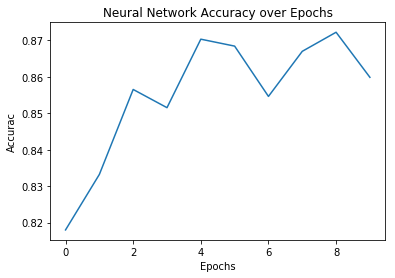

In [229]:
#plotting accuracy over epochs
plt.plot(history.history['val_binary_accuracy'])
plt.title('Neural Network Accuracy over Epochs')
plt.ylabel('Accurac')
plt.xlabel('Epochs');

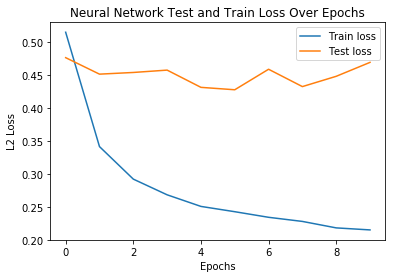

In [230]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend();
plt.title('Neural Network Test and Train Loss Over Epochs')
plt.ylabel('L2 Loss')
plt.xlabel('Epochs');

In [158]:
# as predicted from total data set only around 5% of all samples test positive for WnV
# preliminarily it appears that from upsampling the wnv cases to get a 50/50 test split
# for our neural network we are achieving around 88% accuracy against the test set
# compared to our baseline of 95% we would be better off guessing that all do not have WnV
1 - y_test.sum()/y_test.shape[0]

0.947180585296217

In [159]:
#need to implement a confusion matrix in order to score this appropriately, will never beat 95%
#get keras predictions to make a roc curve/get that roc auc
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))

#calculate AUC
roc_auc = auc(fpr, tpr)
#print a confusion matrix
#confusion_matrix(np.array(y_test), model.predict(X_test))

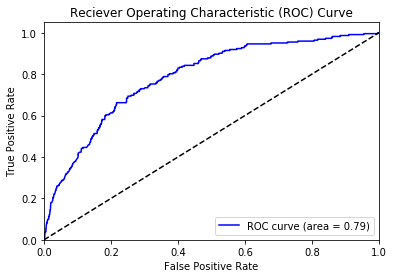

In [160]:
#plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color = 'blue')
plt.plot([0, 1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### B. CART/Decision Trees

In [90]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [91]:
def CART_model_picker(model_list, X_train, y_train, X_test, y_test):
    '''Returns cross-val score and score for all input CART models, returns in sorted order of best performing'''
    results = []
    
    for (k,v) in model_list.items():
        scores = cross_val_score(v, X_train, y_train, cv = 5, n_jobs = -1)
        v.fit(X_train, y_train)
        
        #calculate AUC
        fpr, tpr, _ = roc_curve(y_test, v.predict(X_test))
        roc_auc = auc(fpr, tpr)

        results.append((k, scores.mean(), v.score(X_test, y_test), roc_auc))
    
    results.sort(key = lambda x: x[3], reverse = True)
    
    return results

In [92]:
#setting up stratified kfold
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [105]:
#figure out which CART model performs the best

models = {'Decision Tree': DecisionTreeClassifier(),
          'Extra Trees': ExtraTreesClassifier(),
          'Gradient Boost': GradientBoostingClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Random Forest':RandomForestClassifier(),
          'Bagging': BaggingClassifier()
         }


dt_results = CART_model_picker(models, X_train, y_train, X_test, y_test)

##### XGBoost Model

In [94]:
xgmodel= xgb.XGBClassifier(seed= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, cv = 5, n_jobs = -1)

In [95]:
xgmodel.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.64448	validation_1-auc:0.612813
[1]	validation_0-auc:0.689261	validation_1-auc:0.662271
[2]	validation_0-auc:0.754521	validation_1-auc:0.732405
[3]	validation_0-auc:0.754722	validation_1-auc:0.730539
[4]	validation_0-auc:0.77765	validation_1-auc:0.752828
[5]	validation_0-auc:0.783511	validation_1-auc:0.758694
[6]	validation_0-auc:0.783937	validation_1-auc:0.759135
[7]	validation_0-auc:0.785266	validation_1-auc:0.758942
[8]	validation_0-auc:0.790652	validation_1-auc:0.766767
[9]	validation_0-auc:0.791382	validation_1-auc:0.766899
[10]	validation_0-auc:0.794957	validation_1-auc:0.768013
[11]	validation_0-auc:0.794375	validation_1-auc:0.768183
[12]	validation_0-auc:0.802225	validation_1-auc:0.779654
[13]	validation_0-auc:0.804056	validation_1-auc:0.781576
[14]	validation_0-auc:0.807467	validation_1-auc:0.783379
[15]	validation_0-auc:0.810754	validation_1-auc:0.784034
[16]	validation_0-auc:0.821608	validation_1-auc:0.789853
[17]	validation_0-auc:0.822516	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [96]:
#score the XGBoost model
xgmodel.score(X_test, y_test)

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7487508922198429

In [97]:
#calculate AUC
fpr, tpr, _ = roc_curve(y_test, xgmodel.predict(X_test))
roc_auc = auc(fpr, tpr)

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


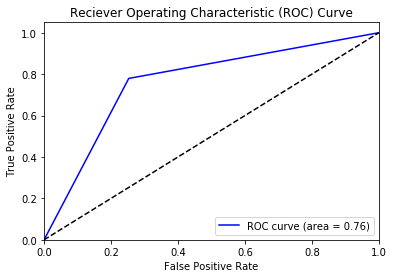

In [98]:
#plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color = 'blue')
plt.plot([0, 1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Generating Model Submission

In [99]:
def create_submission(model):
    '''Generates csv for submission from model using model.predict_proba'''
    #predicting values for submission
    submission = pd.DataFrame(model.predict_proba(test), columns = ['WnvPresent'])
    
    submission.set_index(np.arange(1, test.shape[0] + 1), inplace=True)
    submission = submission.reset_index().rename(columns = {'index':'Id'})
    submission.to_csv('~/Desktop/Git_lessons/Project4/westnilevirussubmission.csv', index = False)
    print('Submission Created')
    

In [100]:
#create submission for neural network
create_submission(model)

116293/116293 [==============================] - 5s 44us/step
Submission Created


In [101]:
#predicting values for submission
submission = pd.DataFrame(xgmodel.predict_proba(test)[:,1], columns = ['WnvPresent'])

submission.set_index(np.arange(1, test.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('~/Desktop/Git_lessons/Project4/westnilevirussubmission.csv', index = False)
print('Submission Created')

Submission Created


In [102]:
#show features for xgboost model
xg_importances = pd.DataFrame(sorted(zip(testnames, xgmodel.feature_importances_), reverse = True), columns = ['Variable', 'Importance']).set_index('Variable')

Text(0.5,1,'XGBoost Feature Importances')

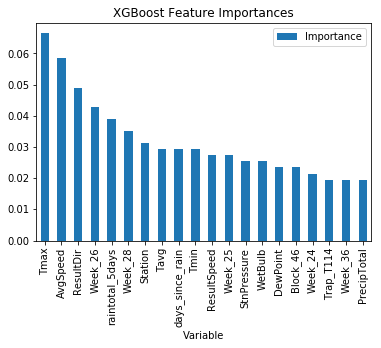

In [207]:
xg_importances.sort_values(by = 'Importance', ascending = False).iloc[:20,:].plot(kind = 'bar')
plt.title('XGBoost Feature Importances')

In [231]:
names = []
scores = []
for dt in dt_results:
    names.append(dt[:][0])
    scores.append(dt[:][2])
    

In [232]:
names

['Gradient Boost',
 'AdaBoost',
 'Decision Tree',
 'Bagging',
 'Random Forest',
 'Extra Trees']

In [233]:
scores

[0.7637401855817273,
 0.728527242445872,
 0.8636688079942898,
 0.8698548655722104,
 0.8843683083511777,
 0.881037354270759]

Text(0.5,1,'Test Scores of CART Models')

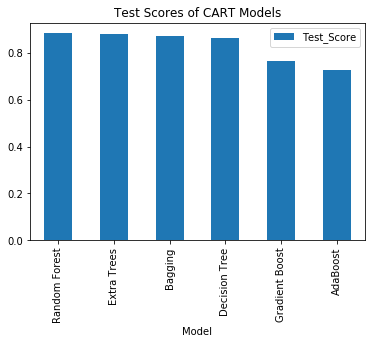

In [234]:
pd.DataFrame(list(zip(names, scores)), columns = ['Model', 'Test_Score']).set_index('Model').sort_values(by = 'Test_Score', ascending = False).plot(kind = 'bar')
plt.title('Test Scores of CART Models')